# 05 – Scaling Cell Models to Module/Pack Level

Goals:
- Simulate module-level capacity fade using cell-level fitted parameters
- Capture:
  1) Cell-to-cell variation
  2) Temperature gradients (optional hook)
  3) Balancing inefficiencies (ideal vs weakest-cell)
- Discuss accuracy vs computational scalability


In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.pack_simulation import *


In [2]:
# ------------------------------------------
# 1. Load your fitted parameters (from sqrt)
# ------------------------------------------
results_df = pd.read_csv("../data/rul_features.csv")
print("Fitted cell params:")
print(results_df)

Fitted cell params:
  cell_id    Q0_fit     a_fit     n_eol
0  Cell_1  2.079547  0.169701  6.006616
1  Cell_2  1.602504  0.143577  4.983009


In [3]:
# Pick base params for Cell_1 and Cell_2
cell1 = results_df[results_df["cell_id"] == "Cell_1"].iloc[0]
cell2 = results_df[results_df["cell_id"] == "Cell_2"].iloc[0]

Q0_1, a_1 = cell1["Q0_fit"], cell1["a_fit"]
Q0_2, a_2 = cell2["Q0_fit"], cell2["a_fit"]

# ------------------------------------------
# 2. Create 8 virtual cells (2 modules, 2s2p)
# ------------------------------------------
# We simulate cell-to-cell variation by sampling
# around the fitted parameters of Cell_1 and Cell_2.

np.random.seed(42)  # for reproducibility

cells_list = []
for i in range(8):
    # Alternate “base types”: Cell_1-like, Cell_2-like
    if i % 2 == 0:
        base_Q0, base_a = Q0_1, a_1
    else:
        base_Q0, base_a = Q0_2, a_2

    # Add small random variation (cell-to-cell spread)
    Q0_i = np.random.normal(base_Q0, 0.02)   # ±0.02 Ah around base
    a_i  = np.random.normal(base_a,  0.005)  # small variation in fade rate

    cells_list.append({
        "idx": i,
        "cell_id": f"cell_{i}",
        "Q0": Q0_i,
        "Q": Q0_i,      # current capacity (updated each cycle)
        "a": a_i,
        "SoC": 1.0,     # simple state-of-charge proxy (0–1)
    })

cells = pd.DataFrame(cells_list)
print("\nInitial virtual cells:")
print(cells)



Initial virtual cells:
   idx cell_id        Q0         Q         a  SoC
0    0  cell_0  2.089482  2.089482  0.169009  1.0
1    1  cell_1  1.615458  1.615458  0.151192  1.0
2    2  cell_2  2.074864  2.074864  0.168530  1.0
3    3  cell_3  1.634089  1.634089  0.147414  1.0
4    4  cell_4  2.070158  2.070158  0.172414  1.0
5    5  cell_5  1.593236  1.593236  0.141248  1.0
6    6  cell_6  2.084387  2.084387  0.160134  1.0
7    7  cell_7  1.568006  1.568006  0.140765  1.0


In [4]:
# ------------------------------------------
# 3. Define module/pack layout (2 modules, 2s2p each)
# ------------------------------------------
# Module 0: cells [0,1] in parallel, then [2,3] in parallel → 2s2p
# Module 1: cells [4,5] in parallel, then [6,7] in parallel → 2s2p

modules = [
    {
        "name": "Module_0",
        "series_groups": [
            [0, 1],   # group 0: two parallel cells
            [2, 3],   # group 1: two parallel cells
        ]
    },
    {
        "name": "Module_1",
        "series_groups": [
            [4, 5],
            [6, 7],
        ]
    }
]

In [6]:
# ------------------------------------------
# 4. Simple balancing inefficiency model
# ------------------------------------------
# NOTE: No temperature used here.
# If temperature data were available, we could make 'a' depend on T
# inside the main degradation loop (e.g. a_eff = a * f(T)).

balancing_events = []

In [ ]:
# ------------------------------------------
# 5. Simulate degradation over cycles
# ------------------------------------------
history = []
N_cycles = 150   # adjust as needed

for cycle in range(1, N_cycles + 1):

    # (A) Normal degradation using your sqrt model (no temperature)
    for idx, row in cells.iterrows():
        Q_new = row["Q0"] - row["a"] * np.sqrt(cycle)
        cells.at[idx, "Q"] = max(Q_new, 0.0)

    # (B) Simple SoC evolution model
    # For a toy model: assume SoC decreases linearly with cycle index
    # just to create some spread; in reality this comes from drive/charge patterns.
    DoD = 0.5  # pretend we use 50% depth-of-discharge over total horizon
    cells["SoC"] = 1.0 - DoD * (cycle / N_cycles)
    cells["SoC"] = cells["SoC"].clip(lower=0.0)

    # (C) Apply balancing once per cycle on each module
    extra_balance_loss_ah = 0.0
    for m in modules:
        extra_balance_loss_ah += apply_balancing(cells, m)

    balancing_events.append({
        "cycle": cycle,
        "extra_loss_ah": extra_balance_loss_ah
    })

    # (D) Compute capacities
    module_caps = [module_capacity(cells, m) for m in modules]
    pack_cap_raw = pack_capacity(cells, modules)
    pack_cap_effective = max(pack_cap_raw - extra_balance_loss_ah, 0.0)
    pack_cap = pack_cap_effective
    

    history.append({
        "cycle": cycle,
        "Module_0_cap": module_caps[0],
        "Module_1_cap": module_caps[1],
        "Pack_cap": pack_cap,
        "Cell_Q_min": cells["Q"].min(),
        "Cell_Q_max": cells["Q"].max(),
        "Cell_Q_spread": cells["Q"].max() - cells["Q"].min(),
    })

history_df = pd.DataFrame(history)
bal_df = pd.DataFrame(balancing_events)


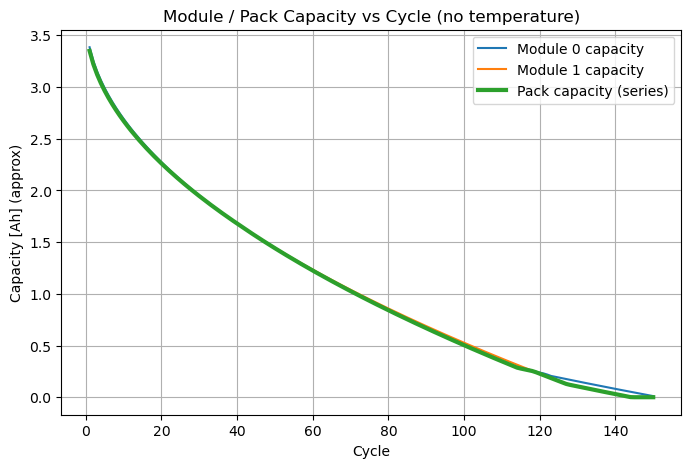

In [8]:
plt.figure(figsize=(8,5))
plt.plot(history_df["cycle"], history_df["Module_0_cap"], label="Module 0 capacity")
plt.plot(history_df["cycle"], history_df["Module_1_cap"], label="Module 1 capacity")
plt.plot(history_df["cycle"], history_df["Pack_cap"], label="Pack capacity (series)", linewidth=3)
plt.xlabel("Cycle")
plt.ylabel("Capacity [Ah] (approx)")
plt.title("Module / Pack Capacity vs Cycle (no temperature)")
plt.grid(True)
plt.legend()
plt.show()

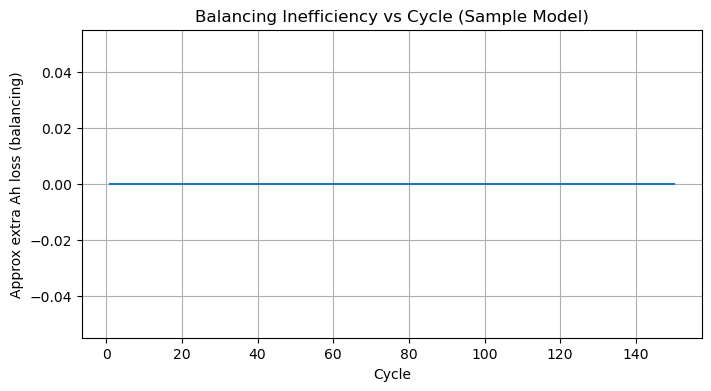

In [9]:
plt.figure(figsize=(8,4))
plt.plot(bal_df["cycle"], bal_df["extra_loss_ah"])
plt.xlabel("Cycle")
plt.ylabel("Approx extra Ah loss (balancing)")
plt.title("Balancing Inefficiency vs Cycle (Sample Model)")
plt.grid(True)
plt.show()
